<a href="https://colab.research.google.com/github/kavyajeetbora/EAST/blob/master/EAST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Imports

[**Tasks - Incidental Scene Text**](https://rrc.cvc.uab.es/?ch=4&com=tasks)

In [0]:
import os
from PIL import Image
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
%%time

!git clone -l -s git://github.com/kavyajeetbora/EAST.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 42 (delta 23), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (42/42), 376.51 KiB | 3.76 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content/cloned-repo
dataset_original.py  EAST_dataset.ipynb        loss.py	 train.py
dataset.py	     EAST_text_detector.ipynb  model.py
CPU times: user 64.7 ms, sys: 19.5 ms, total: 84.2 ms
Wall time: 6.61 s


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
image_address = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/Simple YOLO model/Data/Sample Images'
image_labels = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/Simple YOLO model/Data/Sample Annotations'

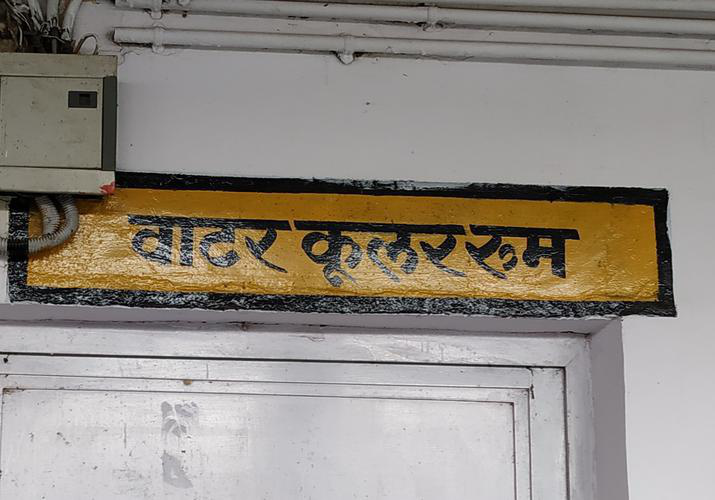

In [5]:
Image.open(image_address+'/0.jpg')

In [6]:
from dataset import custom_dataset
from torch.utils.data import DataLoader

training_dataset = custom_dataset(image_address, image_labels)
print(len(training_dataset))

428


In [7]:
train_loader = DataLoader(training_dataset, batch_size=4, shuffle=True)

img, gt_score, gt_geo, ignored_maps = next(iter(train_loader))
print(img.size(), gt_score.size(), gt_geo.size(), ignored_maps.size())

torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 128, 128]) torch.Size([4, 5, 128, 128]) torch.Size([4, 1, 128, 128])


In [0]:
def extract_vertices(lines):
	'''extract vertices info from txt lines
	Input:
		lines   : list of string info
	Output:
		vertices: vertices of text regions <numpy.ndarray, (n,8)>
		labels  : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
	'''
	labels = []
	vertices = []
	for line in lines:
		x1,x2,x3,x4,y1,y2,y3,y4 = list(map(int,line.rstrip('\n').lstrip('\ufeff').split(',')[:8]))
		vertices.append([x1,y1,x2,y2,x3,y3,x4,y4])
		label = 0 if '##::' in line else 1
		labels.append(label)
	return np.array(vertices), np.array(labels)

In [0]:
with open(image_labels+'/0.txt', 'r') as f:
			lines = f.readlines()
vertices, labels = extract_vertices(lines)

In [10]:
vertices,  labels

(array([[122, 207, 294, 214, 295, 277, 126, 270],
        [291, 213, 469, 221, 472, 283, 303, 287],
        [464, 214, 581, 221, 581, 287, 473, 281]]), array([0, 0, 0]))

In [15]:
from model import EAST

model = EAST()

Downloading: "http://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [02:46<00:00, 3.31MB/s]


In [17]:
pred_score, pred_geo = model(img)
print(pred_score.size(), pred_geo.size())

torch.Size([4, 1, 128, 128]) torch.Size([4, 5, 128, 128])


In [0]:
def get_dice_loss(gt_score, pred_score):
	inter = torch.sum(gt_score * pred_score)
	union = torch.sum(gt_score) + torch.sum(pred_score) + 1e-5
	return 1. - (2 * inter / union)


def get_geo_loss(gt_geo, pred_geo):
	d1_gt, d2_gt, d3_gt, d4_gt, angle_gt = torch.split(gt_geo, 1, 1)
	d1_pred, d2_pred, d3_pred, d4_pred, angle_pred = torch.split(pred_geo, 1, 1)
	area_gt = (d1_gt + d2_gt) * (d3_gt + d4_gt)
	area_pred = (d1_pred + d2_pred) * (d3_pred + d4_pred)
	w_union = torch.min(d3_gt, d3_pred) + torch.min(d4_gt, d4_pred)
	h_union = torch.min(d1_gt, d1_pred) + torch.min(d2_gt, d2_pred)
	area_intersect = w_union * h_union
	area_union = area_gt + area_pred - area_intersect
	iou_loss_map = -torch.log((area_intersect + 1.0)/(area_union + 1.0))
	angle_loss_map = 1 - torch.cos(angle_pred - angle_gt)
	return iou_loss_map, angle_loss_map


In [21]:
get_dice_loss(gt_score, pred_score)

tensor(1., grad_fn=<RsubBackward1>)

In [23]:
iou_loss_map, angle_loss_map = get_geo_loss(gt_geo, pred_geo)
print(iou_loss_map.size(), angle_loss_map.size())

torch.Size([4, 1, 128, 128]) torch.Size([4, 1, 128, 128])


In [0]:
class Loss_EAST(nn.Module):
	def __init__(self, weight_angle=10):
		super(Loss_EAST, self).__init__()
		self.weight_angle = weight_angle

	def forward(self, gt_score, pred_score, gt_geo, pred_geo):
		if torch.sum(gt_score) < 1:
			return torch.sum(pred_score + pred_geo) * 0

		classify_loss = get_dice_loss(gt_score, pred_score)
		iou_loss_map, angle_loss_map = get_geo_loss(gt_geo, pred_geo)

		angle_loss = torch.sum(angle_loss_map*gt_score) / torch.sum(gt_score)
		iou_loss = torch.sum(iou_loss_map*gt_score) / torch.sum(gt_score)
		geo_loss = self.weight_angle * angle_loss + iou_loss
		print('classify loss is {:.8f}, angle loss is {:.8f}, iou loss is {:.8f}'.format(classify_loss, angle_loss, iou_loss))
		return geo_loss + classify_loss

In [35]:
loss_fn = Loss_EAST()

loss_fn(gt_score, pred_score, gt_geo, pred_geo)

tensor(0., grad_fn=<MulBackward0>)

In [39]:
torch.sum(pred_score)

tensor(30606.2500, grad_fn=<SumBackward0>)